# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [2]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. Take a look at the descriptive statistics on the normalized data to show that it has been normalized properly.

In [3]:
# Take a peek at your training set
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


You were asked to normalize the data to be between $0$ and $1$, as opposed to standardizing. To do this we will use the following equation for normalization: 
$$x_i^{\prime} = \frac{x_i - \min{x}}{\max{x} - \min{x}}.$$

Notice that in this case we only use the $\min{x}$ and $\max{x}$ values from the training data to normalize both the training and the testing dataset. 

*Note:* If you didn't want to implement the normalization yourself, you could have also used sklearn's `MinMaxScaler` to accomplish the same thing.

In [4]:
def normalize_columns(X, X_min, X_max):
    return (X-X_min)/(X_max-X_min)

X_min = np.min(data_train,axis=0)
X_max = np.max(data_train,axis=0)

data_train = normalize_columns(X=data_train, X_min=X_min, X_max=X_max)
data_test = normalize_columns(X=data_test, X_min=X_min, X_max=X_max)   

assert np.max(data_train.values)==1 and np.min(data_train.values)==0    

Now you can see that your data values lie between $0$ and $1$.

In [5]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,0.640347,0.719472,0.369477,0.512253,0.529472,0.550653,0.654253,0.581803,0.535615,...,0.385916,0.351822,0.656206,0.173726,0.698519,0.334762,0.283348,0.615608,0.162620,0.404570
std,0.49029,0.182889,0.186767,0.237206,0.243956,0.231075,0.214332,0.216589,0.228836,0.231285,...,0.234882,0.195379,0.217202,0.154501,0.201592,0.204001,0.171412,0.200119,0.202527,0.199781
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.596530,0.631115,0.201744,0.325824,0.386853,0.408101,0.547153,0.484127,0.342807,...,0.247305,0.213235,0.556792,0.104175,0.602778,0.210597,0.200870,0.506906,0.057054,0.243280
50%,0.00000,0.653025,0.745597,0.323256,0.553846,0.584052,0.542683,0.683986,0.634921,0.573086,...,0.370620,0.337596,0.715457,0.143865,0.737037,0.302760,0.281739,0.607735,0.085271,0.416667
75%,1.00000,0.731762,0.844423,0.500000,0.720330,0.683728,0.713850,0.753381,0.739796,0.725058,...,0.498652,0.407289,0.813232,0.195904,0.856481,0.434328,0.342391,0.708564,0.176434,0.512097
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.3:** Notice that the results training set contains significantly more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

In [6]:
data_train.shape

(40, 7130)

* With many more predictors than observations, the model is grossly underidentified/underdetermined. 
* We risk finding spurious relationships between predictors and response.

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

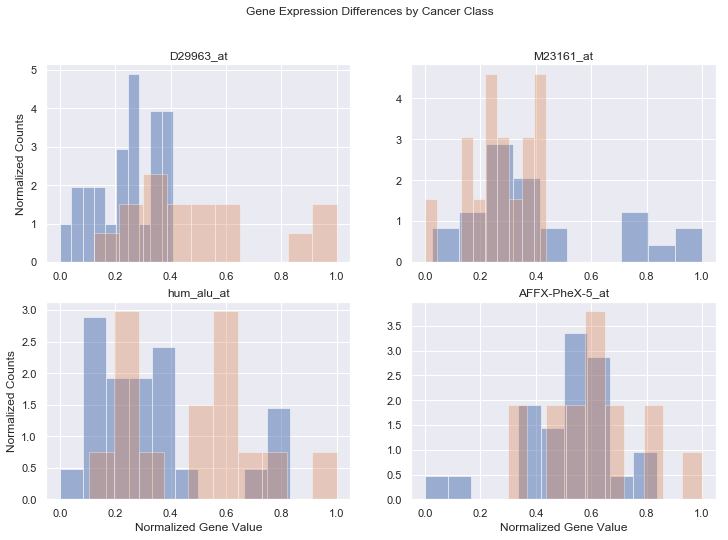

In [7]:
top_alpha = 0.35

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle("Gene Expression Differences by Cancer Class")

ax[0,0].hist(data_train[data_train.Cancer_type == 0]['D29963_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[0,0].hist(data_train[data_train.Cancer_type == 1]['D29963_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[0,0].set_ylabel('Normalized Counts')
ax[0,0].set_title('D29963_at')

ax[0,1].hist(data_train[data_train.Cancer_type == 0]['M23161_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[0,1].hist(data_train[data_train.Cancer_type == 1]['M23161_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[0,1].set_title('M23161_at')

ax[1,0].hist(data_train[data_train.Cancer_type == 0]['hum_alu_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[1,0].hist(data_train[data_train.Cancer_type == 1]['hum_alu_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[1,0].set_title('hum_alu_at')
ax[1,0].set_xlabel('Normalized Gene Value')
ax[1,0].set_ylabel('Normalized Counts')

ax[1,1].hist(data_train[data_train.Cancer_type == 0]['AFFX-PheX-5_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[1,1].hist(data_train[data_train.Cancer_type == 1]['AFFX-PheX-5_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[1,1].set_title('AFFX-PheX-5_at')
ax[1,1].set_xlabel('Normalized Gene Value');

* If the distribution of expression levels differs when `Cancer_type`=0 vs when `Cancer_type`=1, we argue that that gene may be useful in discriminating between cancer types.
* The distributions of gene expression for this subset look very similar across cancer types. `D29963_at` seems the most promising of the bunch.

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

The first two principal components explain 0.273 of the variance.


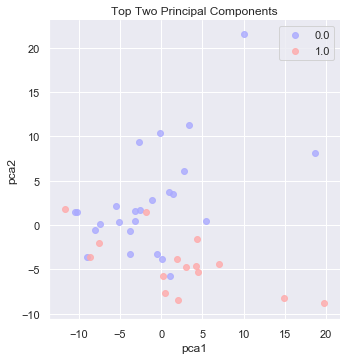

In [8]:
# split out target variable
X_train = data_train.iloc[:,1:]
y_train = data_train.iloc[:,0]
X_test = data_test.iloc[:,1:]
y_test = data_test.iloc[:,0]

# pca
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print("The first two principal components explain %0.3f of the variance."
      % np.sum(pca.explained_variance_ratio_))

# scatter plot
X_train_pca_df = pd.DataFrame(X_train_pca, columns=["pca1", "pca2"])
X_train_pca_df["Cancer_type"] = y_train.values
sns.lmplot(x="pca1", 
           y="pca2", 
           hue="Cancer_type", 
           data=X_train_pca_df,
           fit_reg=False, 
           legend=False, 
           palette='bwr')
plt.title('Top Two Principal Components')
plt.legend();

* It's difficult to draw a decision boundary (even a non-linear one) that perfectly separates red from blue points. However, there’s clearly some useful info in these two components in terms of creating a classifier.

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

In [9]:
# add column to house intercept
X_train_wcons = sm.add_constant(X_train[["D29963_at"]])
X_test_wcons = sm.add_constant(X_test[["D29963_at"]])

# fit
ols = OLS(endog=y_train, exog=X_train_wcons).fit()

* A simple ols model may yield predictions outside [0,1], which are not valid probabilities. 

**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

In [10]:
# predictions
y_hat_ols_train = ols.predict(X_train_wcons)
y_hat_ols_test = ols.predict(X_test_wcons)

# accuracy
print("OLS single predictor accuracy in train = %0.3f" 
      % accuracy_score(y_train, y_hat_ols_train>0.5))

print("OLS single predictor accuracy in test = %0.3f" 
      % accuracy_score(y_test, y_hat_ols_test>0.5))

OLS single predictor accuracy in train = 0.800
OLS single predictor accuracy in test = 0.758


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [11]:
logreg = LogisticRegression(C=100000, fit_intercept=False)
logreg.fit(X_train_wcons, y_train);

In [12]:
y_hat_logreg_train = logreg.predict_proba(X_train_wcons)[:,1]
y_hat_logreg_test = logreg.predict_proba(X_test_wcons)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_logreg_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_logreg_test>0.5))

Training Accuracy: 0.800
Test Accuracy: 0.758


* Logistic regression yields the same accuracy as the linear regression model.

* Note, by “accuracy” here, we just mean the percentage of y_train observations that are perfectly predicted by our model. 

**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

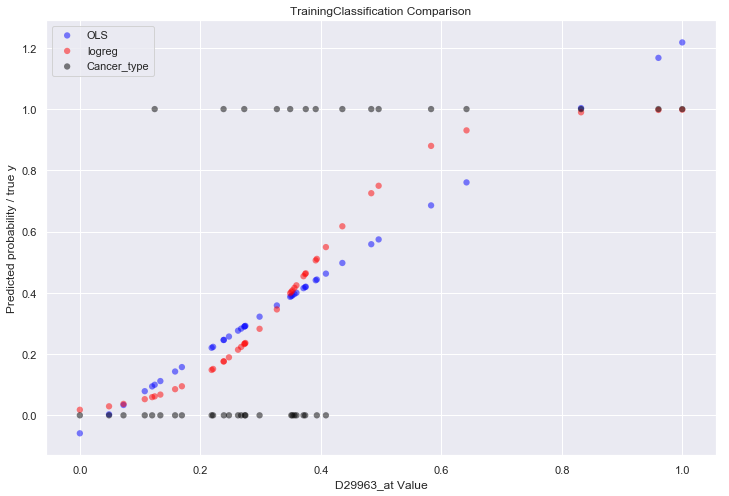

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.suptitle("")

ax.scatter(X_train[["D29963_at"]], 
           y_hat_ols_train, 
           label="OLS", 
           c='blue', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax.scatter(X_train[["D29963_at"]], 
           y_hat_logreg_train, 
           label="logreg", 
           c='red', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax.scatter(X_train[["D29963_at"]], 
           y_train, 
           label="Cancer_type", 
           c='black', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax.legend(loc='best');
ax.set_xlabel('D29963_at Value')
ax.set_ylabel('Predicted probability / true y')
ax.set_title('TrainingClassification Comparison');

* Both OLS and Logistic Regression appear to yield similar predicted values. 
* Based on this figure, the Logistic Regression model does appear to be a better fit. Given that Logistic Regression gives us a valid probability, the Logistic Regression model would be preferred over the OLS model.

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [14]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers:

**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [15]:
logregmul = LogisticRegression(C=100000, fit_intercept=False)

X_train_mul_wcons = sm.add_constant(X_train)
X_test_mul_wcons = sm.add_constant(X_test)

logregmul.fit(X_train_mul_wcons, y_train);

In [16]:
y_hat_logregmul_train = logregmul.predict_proba(X_train_mul_wcons)[:,1]
y_hat_logregmul_test = logregmul.predict_proba(X_test_mul_wcons)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_logregmul_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_logregmul_test>0.5))

Training Accuracy: 1.000
Test Accuracy: 1.000


* Accuracy in both training and test improves considerably with all genes vs a single gene.

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points? 

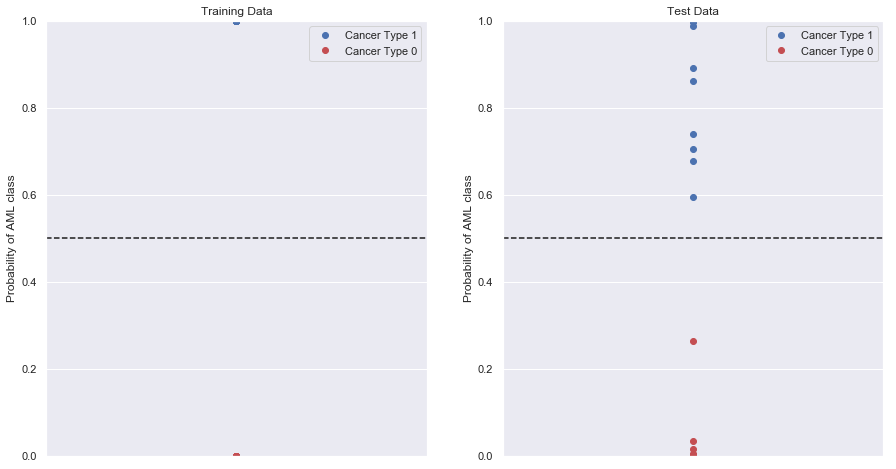

In [17]:
""" Plot classification model """

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

fig.suptitle("")

visualize_prob(logregmul, 
               X_train_mul_wcons, 
               y_train, ax[0])
ax[0].set_title('Training Data')

visualize_prob(logregmul, 
               X_test_mul_wcons, 
               y_test, ax[1])
ax[1].set_title('Test Data');

* In training the probabilities are either 1 or 0. In test probabilities a handful of predicted probabilities fall closer to 0.5. 
* For these points, we are unsure if we should predict $\hat{y}=0$ or $\hat{y}=1$.

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

In [18]:
iterations = 1000

b_genes_boot = np.zeros((X_train_mul_wcons.shape[1],iterations))

for i in range(iterations):
    # sample with replacement from X_train
    boot_rows = np.random.choice(range(X_train_mul_wcons.shape[0]), size=X_train_mul_wcons.shape[0], replace=True)
    X_train_boot = X_train_mul_wcons.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]

    # fit
    logregmul_boot = LogisticRegression(C=100000, fit_intercept=False)
    logregmul_boot.fit(X_train_boot, y_train_boot)
    b_genes_boot[:,i] = logregmul_boot.coef_


In [19]:
# construct confidence intervals
b_genes_ci_upper = np.percentile(b_genes_boot, 97.5, axis=1)
b_genes_ci_lower = np.percentile(b_genes_boot, 2.5, axis=1)

In [20]:
# significant predictors
sig_b_ct = 0

# if ci contains 0, then insignificant
for i in range(X_train_mul_wcons.shape[1]):
    if b_genes_ci_upper[i]<=0 or b_genes_ci_lower[i]>=0:
        sig_b_ct += 1

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, X_train_mul_wcons.shape[1]))

Significant coefficents at 5pct level = 1865 / 7130


* Note that the number of significant predictors varies slightly with each run, but should be in the 1800 range. 

## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

**Answer:**

The amount of the hypercube's volume contained in the hypersphere is 
$$ \frac{\pi^{\frac{d}{2}}} {2^d\Gamma(\frac{d}{2}+1)}. $$

Observe that as $d \rightarrow \infty$ the ratio above goes to $0$. Hence, the hypersphere contains less and less of the volume and $d$ gets larger. In high dimensions, all the volume of the hypercube will be near the surface, which is counterintuitive.

In [21]:
def V_c(d):
    """
    Calculate the volumn of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

In [22]:
rs = [V_s(d)/V_c(d) for d in range(2, 10)]

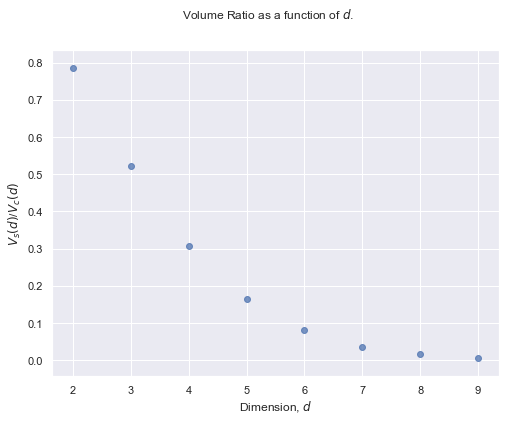

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

fig.suptitle('Volume Ratio as a function of $d$.')

ax.scatter(range(2, 10), rs, alpha=0.75);
ax.set_xlabel("Dimension, $d$")
ax.set_ylabel("$V_s(d)$/$V_c(d)$");

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to use to explain 90% of the variance? How much of the variance do they explain? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [24]:
pca = PCA()
pca.fit(X_train)
var_c = np.cumsum(pca.explained_variance_ratio_)

n_components_pca = np.sum(var_c<0.9)
print("The first %i components explain %0.3f of variance" % (n_components_pca+1, var_c[n_components_pca]))

X_train_pca = pca.transform(X_train)[:,:n_components_pca]
X_test_pca = pca.transform(X_test)[:,:n_components_pca]

The first 29 components explain 0.903 of variance


In [25]:
logregpca = LogisticRegression(C=100000, fit_intercept=True)
logregpca.fit(X_train_pca, y_train)

y_hat_pca_train = logregpca.predict_proba(X_train_pca)[:,1]
y_hat_pca_test = logregpca.predict_proba(X_test_pca)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_pca_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_pca_test>0.5))

Training Accuracy: 1.000
Test Accuracy: 0.970


* The accuracy in train identical for pca + logreg vs logreg. The testing accuracy dropped slightly with PCA. 

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

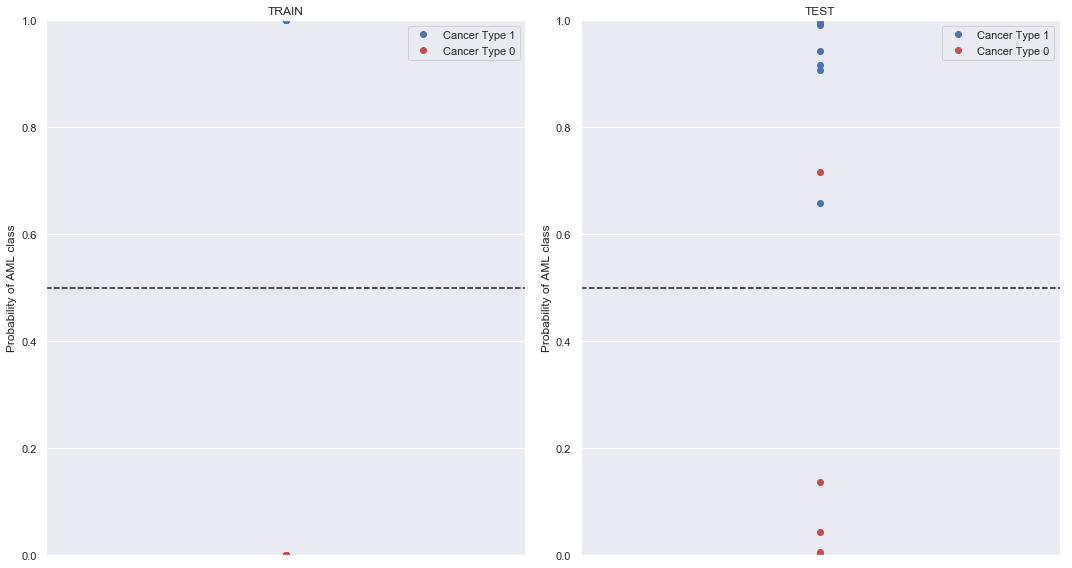

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
visualize_prob(
    model=logregpca,
    x=X_train_pca,
    y=y_train,
    ax=ax1)
ax1.set_title("TRAIN")
visualize_prob(
    model=logregpca,
    x=X_test_pca,
    y=y_test,
    ax=ax2)
ax2.set_title("TEST")
plt.tight_layout()

* With the all-predictor logit model we risk finding spurious relationships between predictors and response.
* Using PCA we hope to find some lower dimensional representation of our predictors that retains our predictive power but hopefully is less vulnerable to overfitting. 
* In training, the pca+logit model is still able to exactly distinguish between ALL and AML. However we see our performance has not improved in test (we have a misclassified point).


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [27]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

In [28]:
#look at the dataframe head
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


#### Answers:

**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

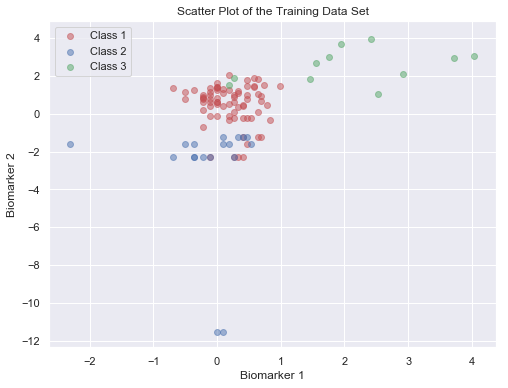

In [29]:
# generate a numpy array of possible responses 
responses = sorted(data_train.Diagnosis.unique())
colors = ['r','b','g']

plt.figure(figsize = (8,6))

for i in range(len(responses)):
    response = responses[i]
    msk = data_train['Diagnosis'] == response 
    plt.scatter(data_train['Biomarker 1'][msk], 
                data_train['Biomarker 2'][msk], 
                c = colors[i],
                label = 'Class ' + str(int(response)),
                alpha=alpha)
    
plt.legend()
plt.title('Scatter Plot of the Training Data Set')
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.show()

Yes, it appears that a linear classifier will work well. By inspection, a linear classifier should be able to correctly classify >90% of the training data points

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

In OvR Logistic Regression the probability of each class is predicted over all of the other classes combined. In Multinomial Logistic Regression one class is set as the reference class and then separate models are used for each of the other classes; comparing each class against the reference class. 


**7.3:** Fit linear classification models on the thyroid data set using both the methods. Is there a difference in the overall classification accuracy of the two methods on the test set?

In [30]:
"""

Note that both OVR and Multinomial Logistic Regression are implemented in SKLearn, chosen with the argument 
'multi_class' - Solver implements some variant of Newton Raphson algorithm, and LogisticRegressionCV by default 
implements L2 Regularization and picks the optimal regularization parameter

"""

#One v. Rest
lrm_ovr = LogisticRegressionCV(multi_class = 'ovr')
lrm_ovr.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

#Multinomial - according to the documentation, the liblinear solver doesn't work for multinomial
lrm_multinomial = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg')
lrm_multinomial.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

#Computing the score on the test set - 
print('OVR Logistic Regression Test Score: ',lrm_ovr.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
print('Multinomial Logistic Regression Test Score: ',lrm_multinomial.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))

OVR Logistic Regression Test Score:  0.840707964602
Multinomial Logistic Regression Test Score:  0.884955752212


* Multinomial does better than One vs. Rest on this particular split of the data

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:

1. Multiclass Logistic Regression with quadratic terms 
1. Linear Discriminant Analysis
1. Quadratic Discriminant Analysis
1. k-Nearest Neighbors

*Note:* You may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in $k$-NN. 


In [31]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])
qda.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])


max_score = 0
max_k = 0 

for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn,data_train.iloc[:,:-1],data_train.iloc[:,-1]).mean()
    if score > max_score:
        max_k = k
        max_score = score

knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(data_train.iloc[:,:-1],data_train.iloc[:,-1])

print('KNN Test Score:', '(Best K is ' + str(max_k) +')',  knn.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
print('LDA Test Score: ',lda.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))
print('QDA Test Score: ',qda.score(data_test.iloc[:,:-1],data_test.iloc[:,-1]))


poly = PolynomialFeatures(degree = 2, include_bias = False)
X_poly_train = poly.fit_transform(data_train.iloc[:,:-1])
X_poly_test = poly.fit_transform(data_test.iloc[:,:-1])
lrm_ovr2 = LogisticRegressionCV(multi_class = 'ovr')
lrm_ovr2.fit(X_poly_train,data_train.iloc[:,-1])
lrm_multinomial2 = LogisticRegressionCV(multi_class = 'multinomial', solver = 'newton-cg')
lrm_multinomial2.fit(X_poly_train,data_train.iloc[:,-1])

print('OVR Poly Logistic Regression Test Score: ',lrm_ovr2.score(X_poly_test,data_test.iloc[:,-1]))
print('Multinomial Poly Logistic Regression Test Score: ',lrm_multinomial2.score(X_poly_test,data_test.iloc[:,-1]))

KNN Test Score: (Best K is 3) 0.867256637168
LDA Test Score:  0.83185840708
QDA Test Score:  0.849557522124
OVR Poly Logistic Regression Test Score:  0.87610619469
Multinomial Poly Logistic Regression Test Score:  0.893805309735


**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms?

* Multinomial Poly Logistic Regression does yield slightly better test accuracy.

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [32]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

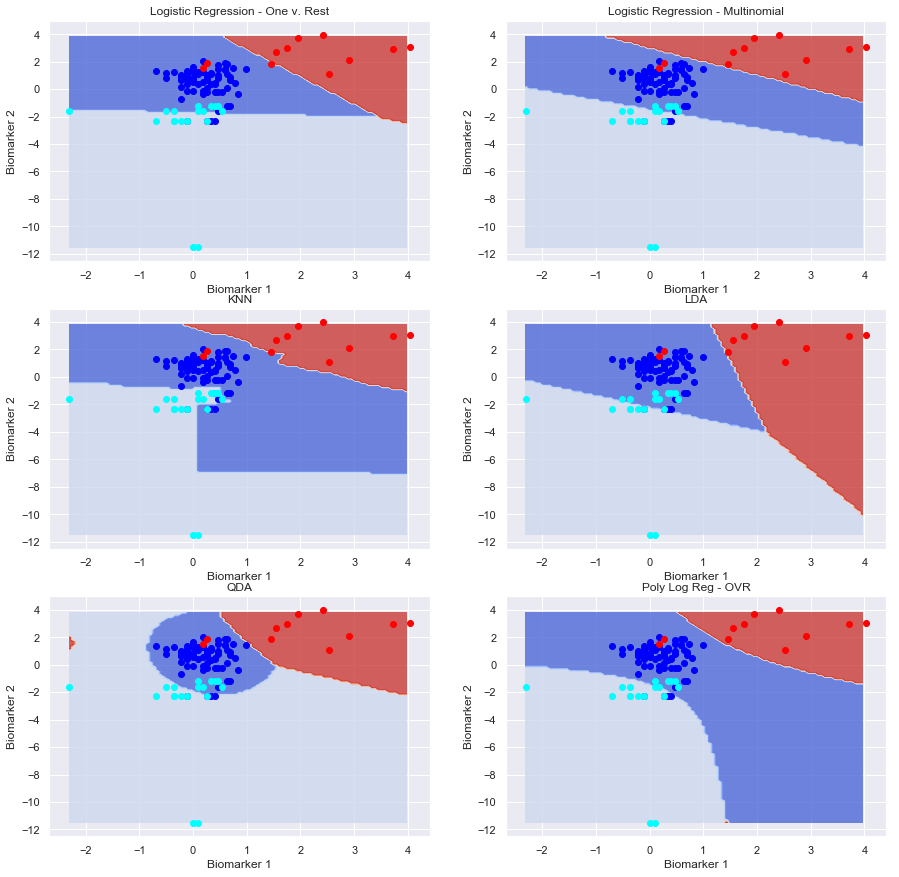

In [33]:
fitted_models = [lrm_ovr, 
                 lrm_multinomial, 
                 knn, lda, qda, 
                 lrm_ovr2, lrm_multinomial2]
titles = ['Logistic Regression - One v. Rest', 
          'Logistic Regression - Multinomial',
          'KNN','LDA','QDA',
          'Poly Log Reg - OVR', 'Poly Log Reg- Multi']

f, axes = plt.subplots(3, 2, figsize = (15,15))
c = 0 
for i in range(len(axes)):
    for j in range(len(axes[0])):
        mod = fitted_models[c]
               
        #hard code the degree of the polynomial ones
        deg = None
        if c == 5 or c == 6:
            deg = 2
            
        plot_decision_boundary(data_train.iloc[:,:-1].values, data_train.iloc[:,-1].values, 
                               mod, titles[c], axes[i,j], poly_degree=deg)
        c += 1
        
        if c == len(fitted_models):
            break

            

**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

* When comparing the OvR and multinomial logistic regression boundaries, both boundaries are linear, but have different slopes and orientations. In looking at the OvR boundaries you can see that they are trying to segment one class from all the remaining classes, and not each class from each other. This explains the differences in the slopes.

* The linear logistic regression model, using OvR, looks similar to the LDA boundaries. When looking at the boundaries for the LDA model, you can see that it is keeping the same covariance over each grouping of points, which in some cases is creating some error (e.g. the boundary separating the dark blue and teal color). As LDA is keeping the covariances the same, we can see that some of the regions, namely the blue region in the middle, is being kept wider than it otherwise may be. That region is more narrow in the logistic regression model between the blue and red regions.

* The quadratic logistic regression and the QDA models seem to have them most exotic looking boundaries. The quadratic logistic regression model is clearly creating quadratic looking lines as the class boundaries. The QDA model is creating a distributional 'ring' around each grouping of points. In the QDA case, we can see that these distributions all have different covariances, which differentiates it from the LDA case.

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

* The difference is that QDA does not assume the covariances are equal.
* This allows QDA to find more complex decision boundaries than LDA